In [1]:
import os
import cv2

# Process Data

## Neurofinder Data

In [2]:
from datasets.neurofinder import \
    scale_pixel_values, \
    tiff_to_png, \
    generate_coco_dict

In [5]:
input_path = "data/train/neurofinder"
output_path = "data/train/neurofinder/png"

# generate .png images from .tiff input data
# tiff_to_png(input_path, output_path)
# get shape of .png images without channel
img_shape = cv2.imread(os.path.join(output_path, os.listdir(output_path)[0])).shape[:2]
# generate coco dict
generate_coco_dict(input_path, output_path, img_shape)

## Naomi data

In [ ]:
def get_32bit_img(filepath) -> np.ndarray:
    # Read the 32-bit TIFF image using tifffile.imread
    image_array = imread(filepath)
    # Perform any necessary preprocessing or type conversion for OpenCV here
    # Example: Converting the 32-bit image to 8-bit
    image_array_8bit = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    return image_array_8bit

In [ ]:
def area_and_simplify_polygon(polygon_coordinates:np.ndarray)->list:
    polygon = Polygon(polygon_coordinates)
    # Simplify the polygon using the Ramer-Douglas-Peucker algorithm
    tolerance = 0.0  
    simplified_polygon = polygon.simplify(tolerance)
    area = simplified_polygon.area
    # Get the coordinates of the simplified polygon
    simplified_polygon_coords = list(simplified_polygon.exterior.coords)
    
    return simplified_polygon_coords, area

In [ ]:
input_folder = "/home/stephan/Desktop/ViNe-Seg/NAOMI Data"
output_folder = "/home/stephan/Desktop/ViNe-Seg/naomi_data_new"

coco_dict = {
    "info": {
        "description": "NAOMI - Max Projection + Masks",
        "url": "internal",
        "version": "1.0",
        "year": 2023,
        "contributor": "AG Stroh",
        "date_created": "2023-03-24"
    },
    "images" : [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "cell",
            "supercategory": "soma"
        }
    ]
}
anno_id = 10_000_000
for i in range(1,151):
    if not os.path.exists(os.path.join(input_folder,f"{i}_mean.tif")):
        print(f"{i}_mean.tif: not found")
        continue
    # load image
    image_path = os.path.join(input_folder,f"{i}_mean.tif")
    img = get_32bit_img(image_path)
    # save image
    img_out_path = os.path.join(output_folder,f"{i}_mean.png")
    cv2.imwrite(img_out_path, img)
    # coco image entry
    coco_image_entry = {
        "id":f"{i}_mean",
        "width":img.shape[1],
        "height":img.shape[0],
        "file_name":f"{i}_mean.png"
    }
    coco_dict['images'].append(coco_image_entry)
    with open(f'NAOMI Data/{i}_polygons.json','r') as j:
        region = json.load(j)
    annos = []
    for roi in region['ROIS']:
        soma, area = area_and_simplify_polygon(roi['coordinates'])
        coco_coord = []
        tmp_x = []
        tmp_y = []
        for x,y in soma:
            coco_coord.append(x)
            coco_coord.append(y)
            tmp_x.append(x)
            tmp_y.append(y)
        # Find the minimum and maximum x coordinates
        min_x, max_x = min(tmp_x), max(tmp_x)
        # Find the minimum and maximum y coordinates
        min_y, max_y = min(tmp_y), max(tmp_y)
        # Construct the bounding box (x, y, width, height)
        bounding_box = [min_x, min_y, max_x - min_x, max_y - min_y]
        coco_coord
        anno_entry = {
                "id": anno_id,
                "image_id":f"{i}_mean",
                "category_id":1,
                "segmentation": [list(coco_coord)],
                "area": area,
                "bbox": bounding_box,
                "iscrowded": 0

            }
        annos.append(anno_entry)
        anno_id += 1
    coco_dict['annotations'] += annos

with open(os.path.join(output_folder,'naomi_coco.json'),'w') as j:
    json.dump(coco_dict,j)

## Allen

In [ ]:
def extract_coordinates_from_mask(mask:np.ndarray)->list:
    # Assume that `roi_matrix` is the binary matrix representing the ROI
    # Find the contours of the binary matrix
    contours = measure.find_contours(mask, 0.5)
    # Assume that there is only one contour for the ROI
    roi_contour = contours[0]
    # Get the x and y coordinates of the contour
    x_coords = roi_contour[:, 1]
    y_coords = roi_contour[:, 0]
    # Create a list of (x, y) tuples for the polygon vertices
    polygon_vertices = [(x, y) for x, y in zip(x_coords, y_coords)]
    # Create a Shapely Polygon from the vertices
    polygon = Polygon(polygon_vertices)
    # Simplify the polygon using the Ramer-Douglas-Peucker algorithm
    tolerance = 0.0  
    simplified_polygon = polygon.simplify(tolerance)
    area = simplified_polygon.area
    # Get the coordinates of the simplified polygon
    simplified_polygon_coords = list(simplified_polygon.exterior.coords)
    return simplified_polygon_coords, area

In [ ]:
from tqdm import tqdm
import time
import allensdk.brain_observatory.behavior.behavior_project_cache as bpc
def save_image_allen(dataset, file_id:str, outpath:str, coco_dict: dict) -> dict:
    # ----------------------------------- image ---------------------------------- #
    # get image and rescale to 0-255 pixel format
    image=np.multiply(np.array(dataset.max_projection),255)
    # save the image
    img_out_path = os.path.join(outpath,f'{file_id}.png')
    cv2.imwrite(img_out_path, image)
    # append to the coco dict
    coco_image_entry = {
        "id":file_id,
        "width":image.shape[1],
        "height":image.shape[0],
        "file_name":f'{file_id}.png'
    }
    # -------------------------- masks and bounding box -------------------------- #
    if len(coco_dict['annotation']) > 0:
        anno_id = coco_dict['annotation'][-1]["id"] + 1
    else:
        anno_id = 0
    coco_annotation_entry = []
    for i,row in dataset.cell_specimen_table.iterrows():
        soma, area = extract_coordinates_from_mask(row['roi_mask'])
        coco_coord = []
        tmp_x = []
        tmp_y = []
        for x,y in soma:
            coco_coord.append(x)
            coco_coord.append(y)
            tmp_x.append(x)
            tmp_y.append(y)
        # Find the minimum and maximum x coordinates
        min_x, max_x = min(tmp_x), max(tmp_x)
        # Find the minimum and maximum y coordinates
        min_y, max_y = min(tmp_y), max(tmp_y)
        # Construct the bounding box (x, y, width, height)
        bounding_box = [min_x, min_y, max_x - min_x, max_y - min_y]
        # append to coco_annotation
        anno_entry = {
            "id": anno_id,
            "image_id":file_id,
            "category_id":1,
            "segmentation":[list(coco_coord)],
            "area": area,
            "bbox": bounding_box,
            "iscrowded": 0

        }
        coco_annotation_entry.append(anno_entry)
        anno_id += 1
    # ------------------------------ merge coco dict ----------------------------- #
    coco_dict['images'].append(coco_image_entry)
    coco_dict['annotations'] += coco_annotation_entry
    with open(os.path.join(outpath,'allen_coco.json','w')) as f:
        json.dump(coco_dict,f)
    return coco_dict

# define empty coco_dict
coco_dict = {
    "info": {
        "description": "Visual Behavior Optical Physiology Datasets - Max Projection + Masks",
        "url": "https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html",
        "version": "1.0",
        "year": 2023,
        "contributor": "Allen Institute for Brain Science",
        "date_created": "2023-03-24"
    },
    "images" : [],
    "annotation": [],
    "categories": [
        {
            "id": 1,
            "name": "cell",
            "supercategory": "soma"
        }
    ]
}

bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir="/home/stephan/Desktop/ViNe-Seg/allen_new")

behavior_session_table = bc.get_behavior_session_table()  
ophys_session_table = bc.get_ophys_session_table()   
experiment_table = bc.get_ophys_experiment_table()
ophys_experiment_id = experiment_table.index[1]

outpath = "/home/stephan/Desktop/ViNe-Seg/traindata"
unnsuccesful = []
for ophys_experiment_id in tqdm(experiment_table.index,total=len(experiment_table.index)):
    try:
        dataset = bc.get_behavior_ophys_experiment(ophys_experiment_id)
        file_id = experiment_table.loc[ophys_experiment_id,'file_id']
        coco_dict = save_image_allen(dataset,file_id,outpath,coco_dict)
    except:
        unnsuccesful.append(ophys_experiment_id)

## OGB1-up

In [ ]:
input_folder = "/home/stephan/Desktop/ViNe-Seg/ogb1-up"
output_folder = "/home/stephan/Desktop/ViNe-Seg/ogb1_up_data_new"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
coco_dict = {
    "info": {
        "description": "OGB1 up - Average Projection + Masks",
        "url": "internal",
        "version": "1.0",
        "year": 2023,
        "date_created": "2023-03-27"
    },
    "images" : [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "cell",
            "supercategory": "soma"
        }
    ]
}
anno_id = 100_000_000
for i in range(1,51):
    if not os.path.exists(os.path.join(input_folder,f"{i}_mean.tif")):
        print(f"{i}_mean.tif: not found")
        continue
    # load image
    image_path = os.path.join(input_folder,f"{i}_mean.tif")
    img = get_32bit_img(image_path)
    # save image
    img_out_path = os.path.join(output_folder,f"{i}_mean.png")
    cv2.imwrite(img_out_path, img)
    # coco image entry
    coco_image_entry = {
        "id":f"{i}_mean",
        "width":img.shape[1],
        "height":img.shape[0],
        "file_name":f"{i}_mean.png"
    }
    coco_dict['images'].append(coco_image_entry)
    with open(os.path.join(input_folder,f'{i}_polygons.json'),'r') as j:
        region = json.load(j)
    annos = []
    for roi in region['ROIS']:
        soma, area = area_and_simplify_polygon(roi['coordinates'])
        coco_coord = []
        tmp_x = []
        tmp_y = []
        for x,y in soma:
            coco_coord.append(x)
            coco_coord.append(y)
            tmp_x.append(x)
            tmp_y.append(y)
        # Find the minimum and maximum x coordinates
        min_x, max_x = min(tmp_x), max(tmp_x)
        # Find the minimum and maximum y coordinates
        min_y, max_y = min(tmp_y), max(tmp_y)
        # Construct the bounding box (x, y, width, height)
        bounding_box = [min_x, min_y, max_x - min_x, max_y - min_y]
        anno_entry = {
                "id": anno_id,
                "image_id":f"{i}_mean",
                "category_id":1,
                "segmentation": [list(coco_coord)],
                "area": area,
                "bbox": bounding_box,
                "iscrowded": 0

            }
        annos.append(anno_entry)
        anno_id += 1
    coco_dict['annotations'] += annos


with open(os.path.join(output_folder,'ogb1_up_coco.json'),'w') as j:
    json.dump(coco_dict,j)

## Detectron 2

In [2]:
import torch
import copy
import yaml
import matplotlib.pyplot as plt
import numpy as np

# detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.modeling import build_model
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import TransformGen
from detectron2.data import \
    transforms as T, \
    DatasetMapper, \
    build_detection_train_loader, \
    MetadataCatalog, \
    DatasetCatalog

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations, use_instance_mask=True)
        return build_detection_train_loader(cfg, mapper=mapper)

class cell_finder:
    def __init__(self, config_file:str, model_checkpoint_url: str, model_name: str, detection_threshold: float = 0.5, cpu_mode: bool = False):
        self.cfg = get_cfg()
        self.config_file = config_file
        self.model_name = model_name
        self.detection_threshold = detection_threshold
        if os.path.exists(model_checkpoint_url):
            self.cfg.merge_from_file(model_checkpoint_url)
            if os.path.exists(os.path.join(self.cfg.OUTPUT_DIR, f"{self.model_name}.pth")):
                self.load_model()
                print(f'Loaded weights from {os.path.join(self.cfg.OUTPUT_DIR, f"{self.model_name}.pth")}')
        else:
            print('No config file, building new model.')
            self.cfg.merge_from_file(model_zoo.get_config_file(config_file))
        with open('train_settings.yaml','r') as f:
            self.train_settings = yaml.load(f,yaml.Loader)
        self.cpu_mode = cpu_mode
        self.model_checkpoint_url = model_checkpoint_url
        self.predictor = None

    def prepare_training(self,coco_jsons:list, filepaths:list)->None:
        self.used_dataset = []
        for json_f,filepath in zip(coco_jsons,filepaths):
            dataset_name = os.path.basename(json_f).split('.json')[0]
            if dataset_name in self.used_dataset:
                tmp_dataset_name = dataset_name
                i = 1
                while tmp_dataset_name in self.used_dataset:
                    tmp_dataset_name = f'{dataset_name}_{i}'
                    i += 1
            register_coco_instances(dataset_name, {}, json_f, filepath)
            self.used_dataset.append(dataset_name)
    
    def train(self):
            self.cfg.DATASETS.TRAIN = (self.used_dataset)
            self.cfg.DATASETS.TEST = ()
            self.cfg.DATALOADER.NUM_WORKERS = self.train_settings['num_workers']
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(self.config_file)
            self.cfg.SOLVER.IMS_PER_BATCH = self.train_settings['batch_size']
            self.cfg.SOLVER.BASE_LR = self.train_settings['learning_rate']
            self.cfg.SOLVER.MAX_ITER = self.train_settings['max_iterations']
            self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
            if self.cpu_mode:
                self.cfg.MODEL.DEVICE='cpu'
            os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)
            self.trainer = MyTrainer(self.cfg) 
            self.trainer.resume_or_load(resume=False)
            self.trainer.train()
    
    def predict(self, img: np.ndarray) -> None:
        self.cfg.MODEL.WEIGHTS = os.path.join(cf.cfg.OUTPUT_DIR, f"{self.model_name}.pth")
        if self.predictor is None:
            self.predictor = DefaultPredictor(self.cfg)
        outputs = self.predictor(img)
        v = Visualizer(img[:, :, ::-1],
                    metadata= MetadataCatalog.get("train"), 
                    scale=0.8,
                    instance_mode=ColorMode.SEGMENTATION
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        return v
    
    def change_threshold(self, threshold: float) -> None:
        if self.detection_threshold != threshold:
            self.detection_threshold = threshold
            self.cfg.ROI_HEADS.SCORE_THRESH_TEST = threshold
            self.predictor = DefaultPredictor(self.cfg)
    
    def save_model(self) -> None:
        with open(self.model_checkpoint_url,'w') as f:
            f.write(self.cfg.dump())
        torch.save(self.trainer.model.state_dict(), os.path.join(self.cfg.OUTPUT_DIR, f"{self.model_name}.pth"))
    
    def load_model(self) -> None:
        self.cfg.MODEL.WEIGHTS = os.path.join(self.cfg.OUTPUT_DIR, f"{self.model_name}.pth")
    

    
# load augmentation
with open('train_settings.yaml','r') as f:
    train_settings = yaml.load(f,yaml.Loader)
augmentations = []
if train_settings['use_augmentation']:
    augmentations = []
    if train_settings['augmentation']['use_random_flip']:
        augmentations.append(T.RandomFlip(train_settings['augmentation']['flip_probability'], horizontal=True, vertical=False))
        augmentations.append(T.RandomFlip(train_settings['augmentation']['flip_probability'], horizontal=False, vertical=True))
    #if train_settings['augmentation']['use_random_crop']:
    #    augmentations.append(T.RandomCrop('relative',train_settings['augmentation']['min_crop_size']))
    if train_settings['augmentation']['use_random_rotation']:
        augmentations.append(T.RandomRotation([train_settings['augmentation']['min_rotation'],train_settings['augmentation']['max_rotation']]))
    if train_settings['augmentation']['use_random_brightness']:
        augmentations.append(T.RandomBrightness(train_settings['augmentation']['brightness_min'],train_settings['augmentation']['brightness_max']))
    if train_settings['augmentation']['use_random_contrast']:
        augmentations.append(T.RandomContrast(train_settings['augmentation']['contrast_min'],train_settings['augmentation']['contrast_max']))
    if train_settings['augmentation']['use_random_saturation']:
        augmentations.append(T.RandomSaturation(train_settings['augmentation']['saturation_min'],train_settings['augmentation']['saturation_max']))

In [4]:
r101 = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
r101_cfg = "mask_rcnn_config.yaml"
# r50 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
# r50_cfg = "mask_rcnn_r50_config.yaml"

In [5]:
cf = cell_finder(r101, r101_cfg, 'mask_rcnn_R_101_FPN_3x')
#'data/train/allen/allen_coco.json',
#'/media/stasys/WD/stephan/vine-seg/train/allen/',
jsons = [
    'data/train/naomi/naomi_coco.json',
    'data/train/neurofinder/png/neurofinder_coco.json',
    'data/train/ogb1_up/ogb1_up_coco.json',
    #'data/train/allen/allen_coco.json',
]
fp = [
    'data/train/naomi/',
    'data/train/neurofinder/png',
    'data/train/ogb1_up/',
    #'data/train/allen/',
]
cf.prepare_training(jsons,fp)

Loaded weights from ./output/mask_rcnn_R_101_FPN_3x.pth


In [17]:
# cf.train()

In [18]:
# cf.save_model()

In [6]:
dataset_dicts_naomi = DatasetCatalog.get("naomi_coco")
#dataset_dicts_allen = DatasetCatalog.get("allen_coco")
dataset_dicts_neurofinder = DatasetCatalog.get("neurofinder_coco")
dataset_dicts_ogb1_up = DatasetCatalog.get("ogb1_up_coco")

In [7]:
from detectron2.utils.visualizer import ColorMode
def plot(dataset: list, model: cell_finder, num: int, threshold: float = 0.5) -> None:
    #model.change_threshold(threshold)
    img = cv2.imread(dataset[num]["file_name"])
    
    gt_visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("train"),scale=0.8,instance_mode=ColorMode.SEGMENTATION)
    gt_vis = gt_visualizer.draw_dataset_dict(dataset[num])
    pred_vis = model.predict(img)
    
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(17,5)
    ax[0].set_title('Input')
    ax[0].imshow(img)
    ax[1].set_title('Groundtruth')
    ax[1].imshow(gt_vis.get_image()[:, :, ::-1])
    ax[2].set_title('Prediction')
    ax[2].imshow(pred_vis.get_image()[:, :, ::-1])
    plt.show()
    

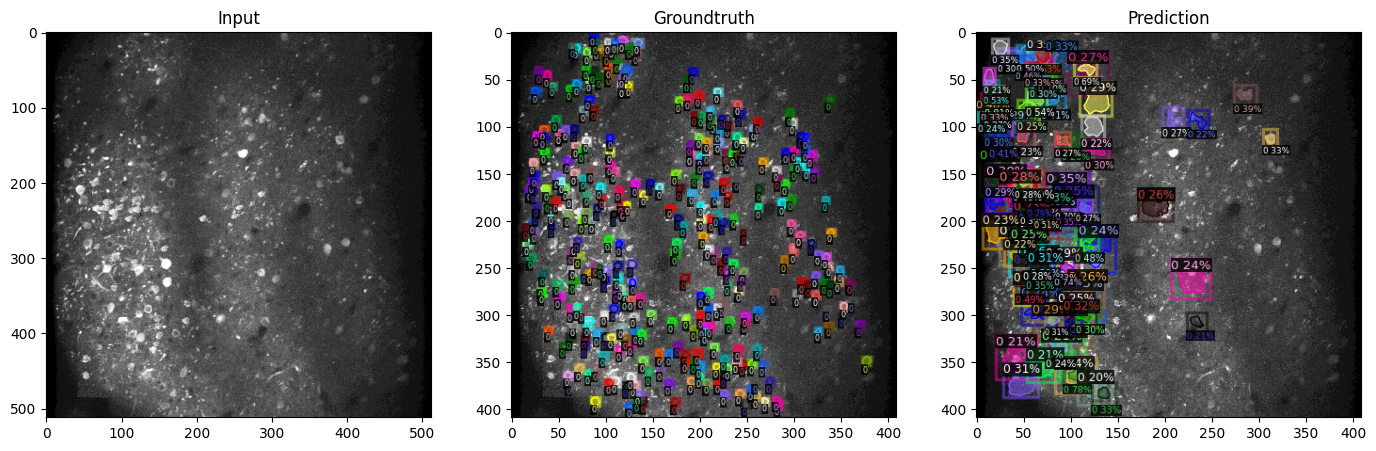

In [16]:
plot(dataset_dicts_neurofinder,cf,0)

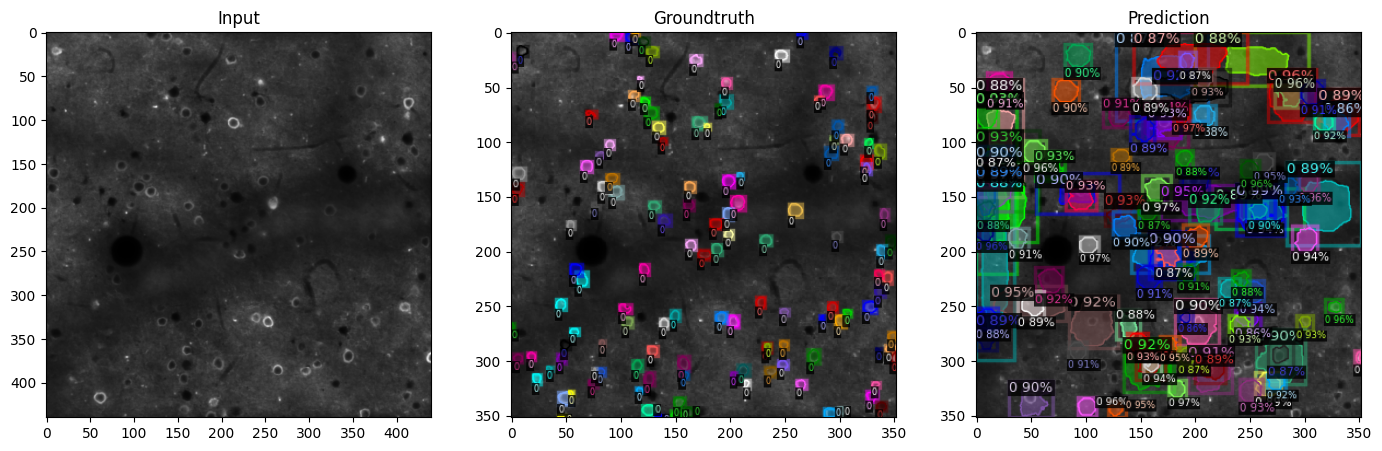

In [18]:
plot(dataset_dicts_naomi,cf,5)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


evaluator = COCOEvaluator("allen_coco", cf.cfg, False, output_dir="output/")
val_loader = build_detection_test_loader(cf.cfg, "allen_coco")

#Use the created predicted model in the previous step
inference_on_dataset(cf.predictor.model, val_loader, evaluator)

In [ ]:
evaluator = COCOEvaluator("naomi_coco", cf.cfg, False, output_dir="output/")
val_loader = build_detection_test_loader(cf.cfg, "naomi_coco")

#Use the created predicted model in the previous step
inference_on_dataset(cf.predictor.model, val_loader, evaluator)

In [ ]:
dataset_dicts_allen[0]

In [ ]:
# Visualize a few images with annotations
for d in dataset_dicts[:10]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("train"),scale=0.8)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()